<a href="https://colab.research.google.com/github/caiocmello/netzdg/blob/main/NetzDG_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import: Run this cell to load the data (use 'df_netzdg_blue&purple.csv' & 'df_colours.csv' as data)

In [ ]:
import pandas as pd
import nltk
import spacy
import plotly.express as px
import plotly.graph_objects as go
import re
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.de.stop_words import STOP_WORDS as de_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Load the data frame into colab
#url = ('/Users/caio.mello/Documents/NetzDG_project/NetzDG_data/df_netzdg_blue&purple.csv')
url = 'df_netzdg_blue&purple.csv'
df = pd.read_csv(url,index_col=0)
#df_colours = pd.read_csv('/Users/caio.mello/Documents/NetzDG_project/NetzDG_data/df_colours.csv', encoding='latin1')
df_colours = pd.read_csv('df_colours.csv', encoding='latin1')
pd.set_option('display.max_colwidth', None)
# prompt: remove duplicated values in column 'text'
df.drop_duplicates(subset='text', inplace=True)
df_colours.drop_duplicates(subset='text', inplace=True)
df_colours = df_colours[['user_username', 'text','retweet_count', 'like_count', 'created_at', 'cluster']]
conc_df = pd.concat([df, df_colours], axis=0)

## Context Analysis

In [50]:
# @title Choose a word to see context (PS: if column 'word' is 'None', word is probably used as hashtag in text)
word = "Freiheit" # @param {type:"string"}

sentences_with_word = conc_df[conc_df['text'].str.contains(word, case=False, na=False)]

# Split the sentences at the word 'x'
split_sentences = sentences_with_word['text'].str.split(word, n=1, expand=True)

# Rename the columns
split_sentences.columns = ['Before', 'After']
split_sentences.insert(1, 'word', word)
split_sentences['word'] = split_sentences.apply(lambda row: 'None' if pd.isnull(row['After']) else row['word'], axis=1)
#split_sentences
merged_df = pd.concat([split_sentences, conc_df], axis=1)
merged_df = merged_df[['user_username','Before', 'word', 'After', 'retweet_count', 'like_count', 'created_at', 'cluster']]
merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns=['index'])
merged_df = merged_df.dropna(subset=['Before'])
merged_df

,user_username,Before,word,After,retweet_count,like_count,created_at,cluster
0,hwieduwilt,"Internetkonzerne löschen wegen politischen Drucks mehr als zuvor, aber niemand weiß, ob sie dabei neutral vorgehen. Das kommt davon, wenn der Staat den Druck erhöht. #meinungsfreiheit #netzdg",None,None,8.0,31.0,2018-07-27T07:26:32.000Z,blue
1,Piratenpartei,"Da sind wir wieder mit den #Piraten-Leseempfehlungen zur Sonntagslektüre.\r\nTeil 1: Ein Beitrag von @echo_pbreyer: ""Leserkommentare im Netz: Keine Kapitulation vor Missbrauch der Meinungsfreiheit!""\r\nhttps://t.co/GivxvRuqtz\r\n#NetzDG #FAZ https://t.co/RBsIzbtoed",None,None,12.0,7.0,2018-08-26T08:00:00.000Z,blue
2,sas_assion,"@MafiGudarzi Es sind indirekte Wirkungen. Das #NetzDG erhöht die Anreize, bestimmte ""Störenfriede"" (von denen eine Bußgeldgefahr ausgeht) gleich ganz von der Plattform zu drängen. Das hat dann den Effekt, dass auch Äußerungen unterdrückt werden, die von der #Meinungsfreiheit gedeckt sind.",None,None,0.0,0.0,2018-08-29T17:15:14.000Z,blue
3,nhaerting,"Das ist eine schlechte Nachricht. Hatte sich #Google bei der Diskussion um das ""Recht auf Vergessen"" engagiert für die Kommunikationsfreiheit eingesetzt, hält man dies jetzt beim #NetzDG offenbar nicht mehr für opportun. #fail https://t.co/dgN8YKBJwe",None,None,1.0,6.0,2018-09-26T09:44:50.000Z,blue
4,hwieduwilt,"@Chr_Rath Ja, je nach Kontext kann Overblocking sich auf das Recht oder die TOS/Richtlinien beziehen. Das NetzDG hat sowohl als auch verursacht. Die Plattformen wollen möglichst viel",Freiheit,"und Kontrolle - aber sicher kein Overblocking, also eine Softwarefehlleistung.",0.0,0.0,2018-10-17T12:30:28.000Z,blue
...,...,...,...,...,...,...,...,...
662,Arnd_Diringer,"Es wäre sinnvoll das Meinungsfreiheits-Verhinderungsgesetz (= #NetzDG) abzuschaffen und (auch im Hinblick auf die ""immense Macht"" der ""sozialen Medien) über ein Meinungsfreiheits-Sicherungsgesetz nachzudenken. https://t.co/P7Jp3Z7gFC",None,None,45.0,117.0,2018-04-09T11:05:25.000Z,orange
663,olivergorus,"@neythomas Meinungsfreiheit ist nur Bürgern etwas wert. Fast alle Berufspolitiker aller Parteien wissen gar nicht, warum wir davon so ein Aufhebens machen, siehe Bundestagsabstimmung zum NetzDG.",None,None,1.0,5.0,2018-04-30T07:11:11.000Z,orange
664,nicolabeerfdp,"RT @FDPamHackeschen @AuswaertigesAmt @HeikoMaas In Sachen #Pressefreiheit wäre @HeikoMaas noch glaubwürdiger, wenn er nicht mit dem #NetzDG ein Monster geschaffen hätte, welches seither für diverse Unrechtsregime in der Welt als Blaupause dient (au) #FDP #TagDerPressefreiheit",None,None,9.0,0.0,2018-05-03T17:46:14.000Z,orange
665,nicolabeerfdp,"""The Cleaners"", ein Film über die Löschteams bei Social Media Betreibern und die Frage, ob große Konzerne damit über unser Denken bestimmen. \r\n(Team Beer)\r\n#NetzDG #Meinungsfreiheit #Facebook https://t.co/RhPPp5jrdF via @faznet @Liberale_News",None,None,9.0,16.0,2018-05-17T12:20:39.000Z,orange


In [ ]:
# Count how many tweets were posted by user containing the above searched word 
merged_df['user_username'].value_counts()

user_username
DrDavidBerger      58
Frank_Pasemann     45
JoanaCotar         29
Piratenpartei      27
lawyerberlin       23
RolandTichy        23
nhaerting          21
PetrBystronAfD     17
AfDimBundestag     14
hwieduwilt          9
heiseonline         7
sas_assion          7
TichysEinblick      7
Beatrix_vStorch     6
dushanwegner        6
ReporterOG          5
Joerg_Meuthen       5
Alice_Weidel        4
SteinbachErika      3
netzpolitik         3
Steinhoefel         2
zeitonline          2
golem               1
sls_fdp             1
Name: count, dtype: int64

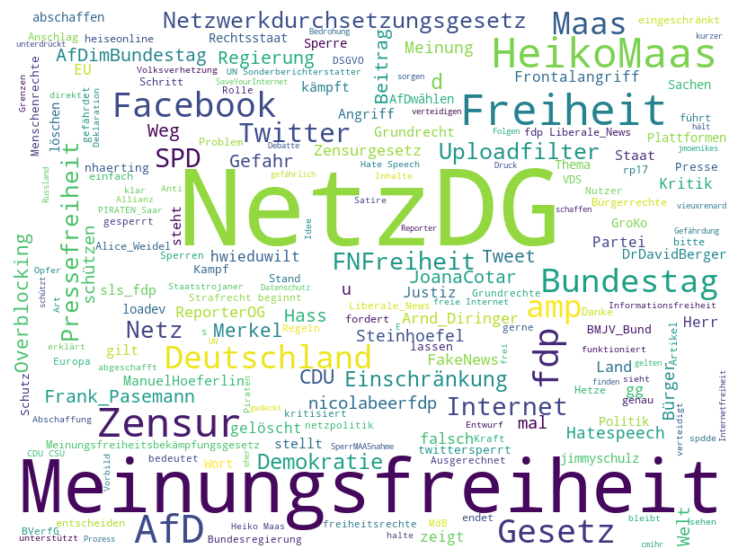

In [56]:
# @title Generate a wordcloud with the most mentioned words in text where the word chosen above is mentioned
# prompt: create a wordcloud with words mentioned in column 'text' when word 'Zensur' is found

from wordcloud import WordCloud
import matplotlib.pyplot as plt

stopwords_de = list(de_stopwords)
stopwords_en = list(en_stopwords)
stopwords = stopwords_de + stopwords_en #create a mixed list of stopwords (German and English)
# Edit your list of stopwords manually
add_to_stopwords = ['rt', 'https', 't', 'co']
stopwords = stopwords + add_to_stopwords

sentences_with_word = conc_df[conc_df['text'].str.contains(word, case=False, na=False)]
text = " ".join(sentences_with_word['text'].tolist())

wordcloud = WordCloud(width=800, height=600, background_color='white', stopwords=stopwords).generate(text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [57]:
# @title Choose a word to see context per cluster (blue or purple)
cluster = 'orange' # @param {type:"string"}

df_cluster = conc_df[conc_df['cluster'] == cluster]
sentences_with_word_cluster = df_cluster[df_cluster['text'].str.contains(word, case=False, na=False)]

# Split the sentences at the word 'x'
split_sentences_cluster = sentences_with_word_cluster['text'].str.split(word, n=1, expand=True)

# Rename the columns
split_sentences_cluster.columns = ['Before', 'After']
split_sentences_cluster.insert(1, 'word', word)
split_sentences_cluster['word'] = split_sentences_cluster.apply(lambda row: 'None' if pd.isnull(row['After']) else row['word'], axis=1)
split_sentences_cluster

,Before,word,After
6,"RT @fdp #NetzDG: Volksverhetzung + Fake News müssen unterbunden werden. Es ist die Aufgabe von Polizei =n\rB &amp; Justiz =i\r, zu entscheiden, was Meinungsfreiheit/Kunstfreiheit ist. Wir haben deshalb beantragt, das NetzDG abzuschaffen, so @nicolabeerfdp. =I https://t.co/frrbSVAbT4 https://t.co/hlS0YWakWt",None,None
10,F.A.Z. exklusiv: #FDP-Politiker klagen gegen das #Netzwerkdurchsetzungsgesetz https://t.co/z36fbAAMsK via @faznet #NetzDG\r\n@Liberale_News @loadev @c_netz @fdp @fdpbt #Meinungsfreiheit #Zensur,None,None
18,RT @FN,Freiheit,"Die erste Klage gegen das #NetzDG durch @jimmyschulz &amp; @ManuelHoeferlin läuft! Hier unsere 5 Gründe, warum sich #Fakenews und #Hatespeech nicht per Gesetz verhindern lassen: https://t.co/9H4znq51hd https://t.co/z3Vv9HT22l"
19,"RT @fdp Gerichte brauchen lang, um festzustellen, was Satire ist. Facebook- und Twitter-Mitarbeiter soll das innerhalb kurzer Zeit entscheiden. Das kann nicht sein. #NetzDG #Kunstfreiheit Gersdorf",None,None
21,"Gerichte brauchen lang, um festzustellen, was Satire ist. Facebook- und Twitter-Mitarbeiter soll das innerhalb kurzer Zeit entscheiden. Das kann nicht sein. #NetzDG #Kunstfreiheit Gersdorf",None,None
...,...,...,...
1532,"Es wäre sinnvoll das Meinungsfreiheits-Verhinderungsgesetz (= #NetzDG) abzuschaffen und (auch im Hinblick auf die ""immense Macht"" der ""sozialen Medien) über ein Meinungsfreiheits-Sicherungsgesetz nachzudenken. https://t.co/P7Jp3Z7gFC",None,None
1540,"@neythomas Meinungsfreiheit ist nur Bürgern etwas wert. Fast alle Berufspolitiker aller Parteien wissen gar nicht, warum wir davon so ein Aufhebens machen, siehe Bundestagsabstimmung zum NetzDG.",None,None
1541,"RT @FDPamHackeschen @AuswaertigesAmt @HeikoMaas In Sachen #Pressefreiheit wäre @HeikoMaas noch glaubwürdiger, wenn er nicht mit dem #NetzDG ein Monster geschaffen hätte, welches seither für diverse Unrechtsregime in der Welt als Blaupause dient (au) #FDP #TagDerPressefreiheit",None,None
1554,"""The Cleaners"", ein Film über die Löschteams bei Social Media Betreibern und die Frage, ob große Konzerne damit über unser Denken bestimmen. \r\n(Team Beer)\r\n#NetzDG #Meinungsfreiheit #Facebook https://t.co/RhPPp5jrdF via @faznet @Liberale_News",None,None


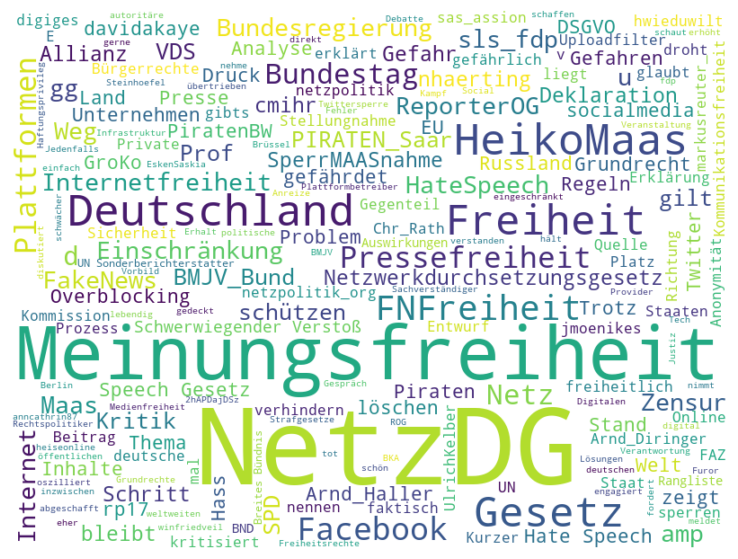

In [59]:
# @title Generate a wordcloud for BLUE
# prompt: create a wordcloud with words mentioned in column 'text' when word 'Zensur' is found

df_blue = conc_df[conc_df['cluster'] == 'blue']
df_purple = conc_df[conc_df['cluster'] == 'purple']
sentences_with_word_blue = df_blue[df_blue['text'].str.contains(word, case=False, na=False)]
sentences_with_word_purple = df_purple[df_purple['text'].str.contains(word, case=False, na=False)]

text_blue = " ".join(sentences_with_word_blue['text'].tolist())
text_purple = " ".join(sentences_with_word_purple['text'].tolist())

wordcloud_b = WordCloud(width=800, height=600, background_color='white', stopwords=stopwords).generate(text_blue)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_b, interpolation='bilinear')
plt.axis('off')
plt.show()

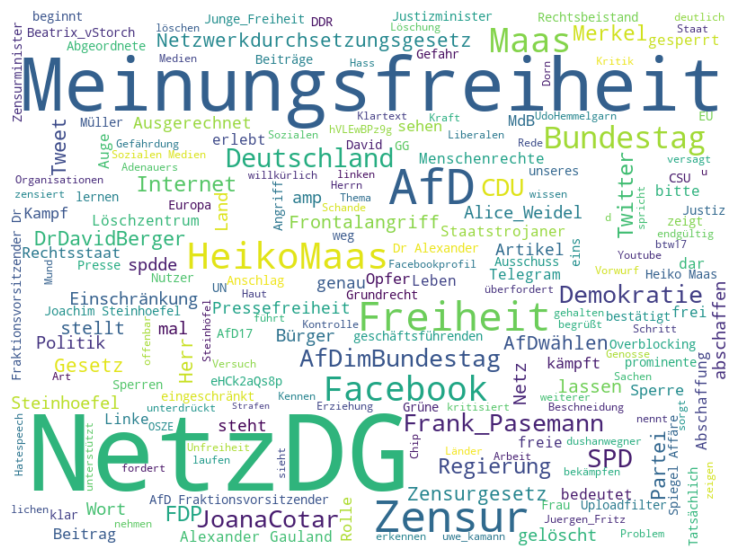

In [60]:
# @title Generate a wordcloud for PURPLE
wordcloud_p = WordCloud(width=800, height=600, background_color='white', stopwords=stopwords).generate(text_purple)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_p, interpolation='bilinear')
plt.axis('off')
plt.show()